In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
from scipy.stats import zscore
from sklearn.preprocessing import power_transform
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
import pickle

# Data Loading

Source:
    https://www.kaggle.com/datasets/nicholasjhana/energy-consumption-generation-prices-and-weather

In [2]:
weather_pred=pd.read_csv('weather_features.csv')
weather_pred

,dt_iso,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,2015-01-01 00:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
1,2015-01-01 01:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2,2015-01-01 02:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
3,2015-01-01 03:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
4,2015-01-01 04:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178391,2018-12-31 19:00:00+01:00,Seville,287.760,287.150,288.150,1028,54,3,30,0.0,0.0,0.0,0,800,clear,sky is clear,01n
178392,2018-12-31 20:00:00+01:00,Seville,285.760,285.150,286.150,1029,62,3,30,0.0,0.0,0.0,0,800,clear,sky is clear,01n
178393,2018-12-31 21:00:00+01:00,Seville,285.150,285.150,285.150,1028,58,4,50,0.0,0.0,0.0,0,800,clear,sky is clear,01n
178394,2018-12-31 22:00:00+01:00,Seville,284.150,284.150,284.150,1029,57,4,60,0.0,0.0,0.0,0,800,clear,sky is clear,01n


# DataPreprocessing 

    1. Extracting date/time/month/year/hour/day/weekday/quarter

In [3]:
weather_pred['date']=pd.to_datetime(weather_pred['dt_iso'].str[:10])
weather_pred['time']=pd.to_datetime(weather_pred['dt_iso'].str[11:19])
weather_pred['month']=weather_pred['date'].dt.month
weather_pred['year']=weather_pred['date'].dt.year
weather_pred['hour']=weather_pred['time'].dt.hour
weather_pred['day']=weather_pred['date'].dt.day
weather_pred['weekday']=weather_pred['date'].dt.weekday
weather_pred['quarter']=weather_pred['date'].dt.quarter

In [4]:
weather_pred

,dt_iso,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,...,weather_description,weather_icon,date,time,month,year,hour,day,weekday,quarter
0,2015-01-01 00:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,...,sky is clear,01n,2015-01-01,2023-05-16 00:00:00,1,2015,0,1,3,1
1,2015-01-01 01:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,...,sky is clear,01n,2015-01-01,2023-05-16 01:00:00,1,2015,1,1,3,1
2,2015-01-01 02:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,...,sky is clear,01n,2015-01-01,2023-05-16 02:00:00,1,2015,2,1,3,1
3,2015-01-01 03:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,...,sky is clear,01n,2015-01-01,2023-05-16 03:00:00,1,2015,3,1,3,1
4,2015-01-01 04:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,...,sky is clear,01n,2015-01-01,2023-05-16 04:00:00,1,2015,4,1,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178391,2018-12-31 19:00:00+01:00,Seville,287.760,287.150,288.150,1028,54,3,30,0.0,...,sky is clear,01n,2018-12-31,2023-05-16 19:00:00,12,2018,19,31,0,4
178392,2018-12-31 20:00:00+01:00,Seville,285.760,285.150,286.150,1029,62,3,30,0.0,...,sky is clear,01n,2018-12-31,2023-05-16 20:00:00,12,2018,20,31,0,4
178393,2018-12-31 21:00:00+01:00,Seville,285.150,285.150,285.150,1028,58,4,50,0.0,...,sky is clear,01n,2018-12-31,2023-05-16 21:00:00,12,2018,21,31,0,4
178394,2018-12-31 22:00:00+01:00,Seville,284.150,284.150,284.150,1029,57,4,60,0.0,...,sky is clear,01n,2018-12-31,2023-05-16 22:00:00,12,2018,22,31,0,4


In [5]:
weather_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178396 entries, 0 to 178395
Data columns (total 25 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   dt_iso               178396 non-null  object        
 1   city_name            178396 non-null  object        
 2   temp                 178396 non-null  float64       
 3   temp_min             178396 non-null  float64       
 4   temp_max             178396 non-null  float64       
 5   pressure             178396 non-null  int64         
 6   humidity             178396 non-null  int64         
 7   wind_speed           178396 non-null  int64         
 8   wind_deg             178396 non-null  int64         
 9   rain_1h              178396 non-null  float64       
 10  rain_3h              178396 non-null  float64       
 11  snow_3h              178396 non-null  float64       
 12  clouds_all           178396 non-null  int64         
 13  weather_id    

In [6]:
# Prepare the data for analysis.
# Drop the columns that are not required for analysis.
weather_pred.drop(['dt_iso','city_name','weather_description','date','time'],axis=1,inplace=True)

In [7]:
weather_pred

,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_icon,month,year,hour,day,weekday,quarter
0,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,01n,1,2015,0,1,3,1
1,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,01n,1,2015,1,1,3,1
2,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,01n,1,2015,2,1,3,1
3,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,01n,1,2015,3,1,3,1
4,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,01n,1,2015,4,1,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178391,287.760,287.150,288.150,1028,54,3,30,0.0,0.0,0.0,0,800,clear,01n,12,2018,19,31,0,4
178392,285.760,285.150,286.150,1029,62,3,30,0.0,0.0,0.0,0,800,clear,01n,12,2018,20,31,0,4
178393,285.150,285.150,285.150,1028,58,4,50,0.0,0.0,0.0,0,800,clear,01n,12,2018,21,31,0,4
178394,284.150,284.150,284.150,1029,57,4,60,0.0,0.0,0.0,0,800,clear,01n,12,2018,22,31,0,4


    2. Check for null values.

In [8]:
weather_pred.isnull().sum()

temp            0
temp_min        0
temp_max        0
pressure        0
humidity        0
wind_speed      0
wind_deg        0
rain_1h         0
rain_3h         0
snow_3h         0
clouds_all      0
weather_id      0
weather_main    0
weather_icon    0
month           0
year            0
hour            0
day             0
weekday         0
quarter         0
dtype: int64

    3. Check for duplicates

In [9]:
weather_pred.duplicated().sum()

27

    4. Encoding the columns

In [10]:
# label encoding
le=LabelEncoder()
weather_pred['weather_main']=le.fit_transform(weather_pred['weather_main'])
weather_pred['weather_icon']=le.fit_transform(weather_pred['weather_icon'])
weather_pred

,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_icon,month,year,hour,day,weekday,quarter
0,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,0,2,1,2015,0,1,3,1
1,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,0,2,1,2015,1,1,3,1
2,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,0,2,1,2015,2,1,3,1
3,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,0,2,1,2015,3,1,3,1
4,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,0,2,1,2015,4,1,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178391,287.760,287.150,288.150,1028,54,3,30,0.0,0.0,0.0,0,800,0,2,12,2018,19,31,0,4
178392,285.760,285.150,286.150,1029,62,3,30,0.0,0.0,0.0,0,800,0,2,12,2018,20,31,0,4
178393,285.150,285.150,285.150,1028,58,4,50,0.0,0.0,0.0,0,800,0,2,12,2018,21,31,0,4
178394,284.150,284.150,284.150,1029,57,4,60,0.0,0.0,0.0,0,800,0,2,12,2018,22,31,0,4


    5.  Check for outliers and Remove Outliers (if any)

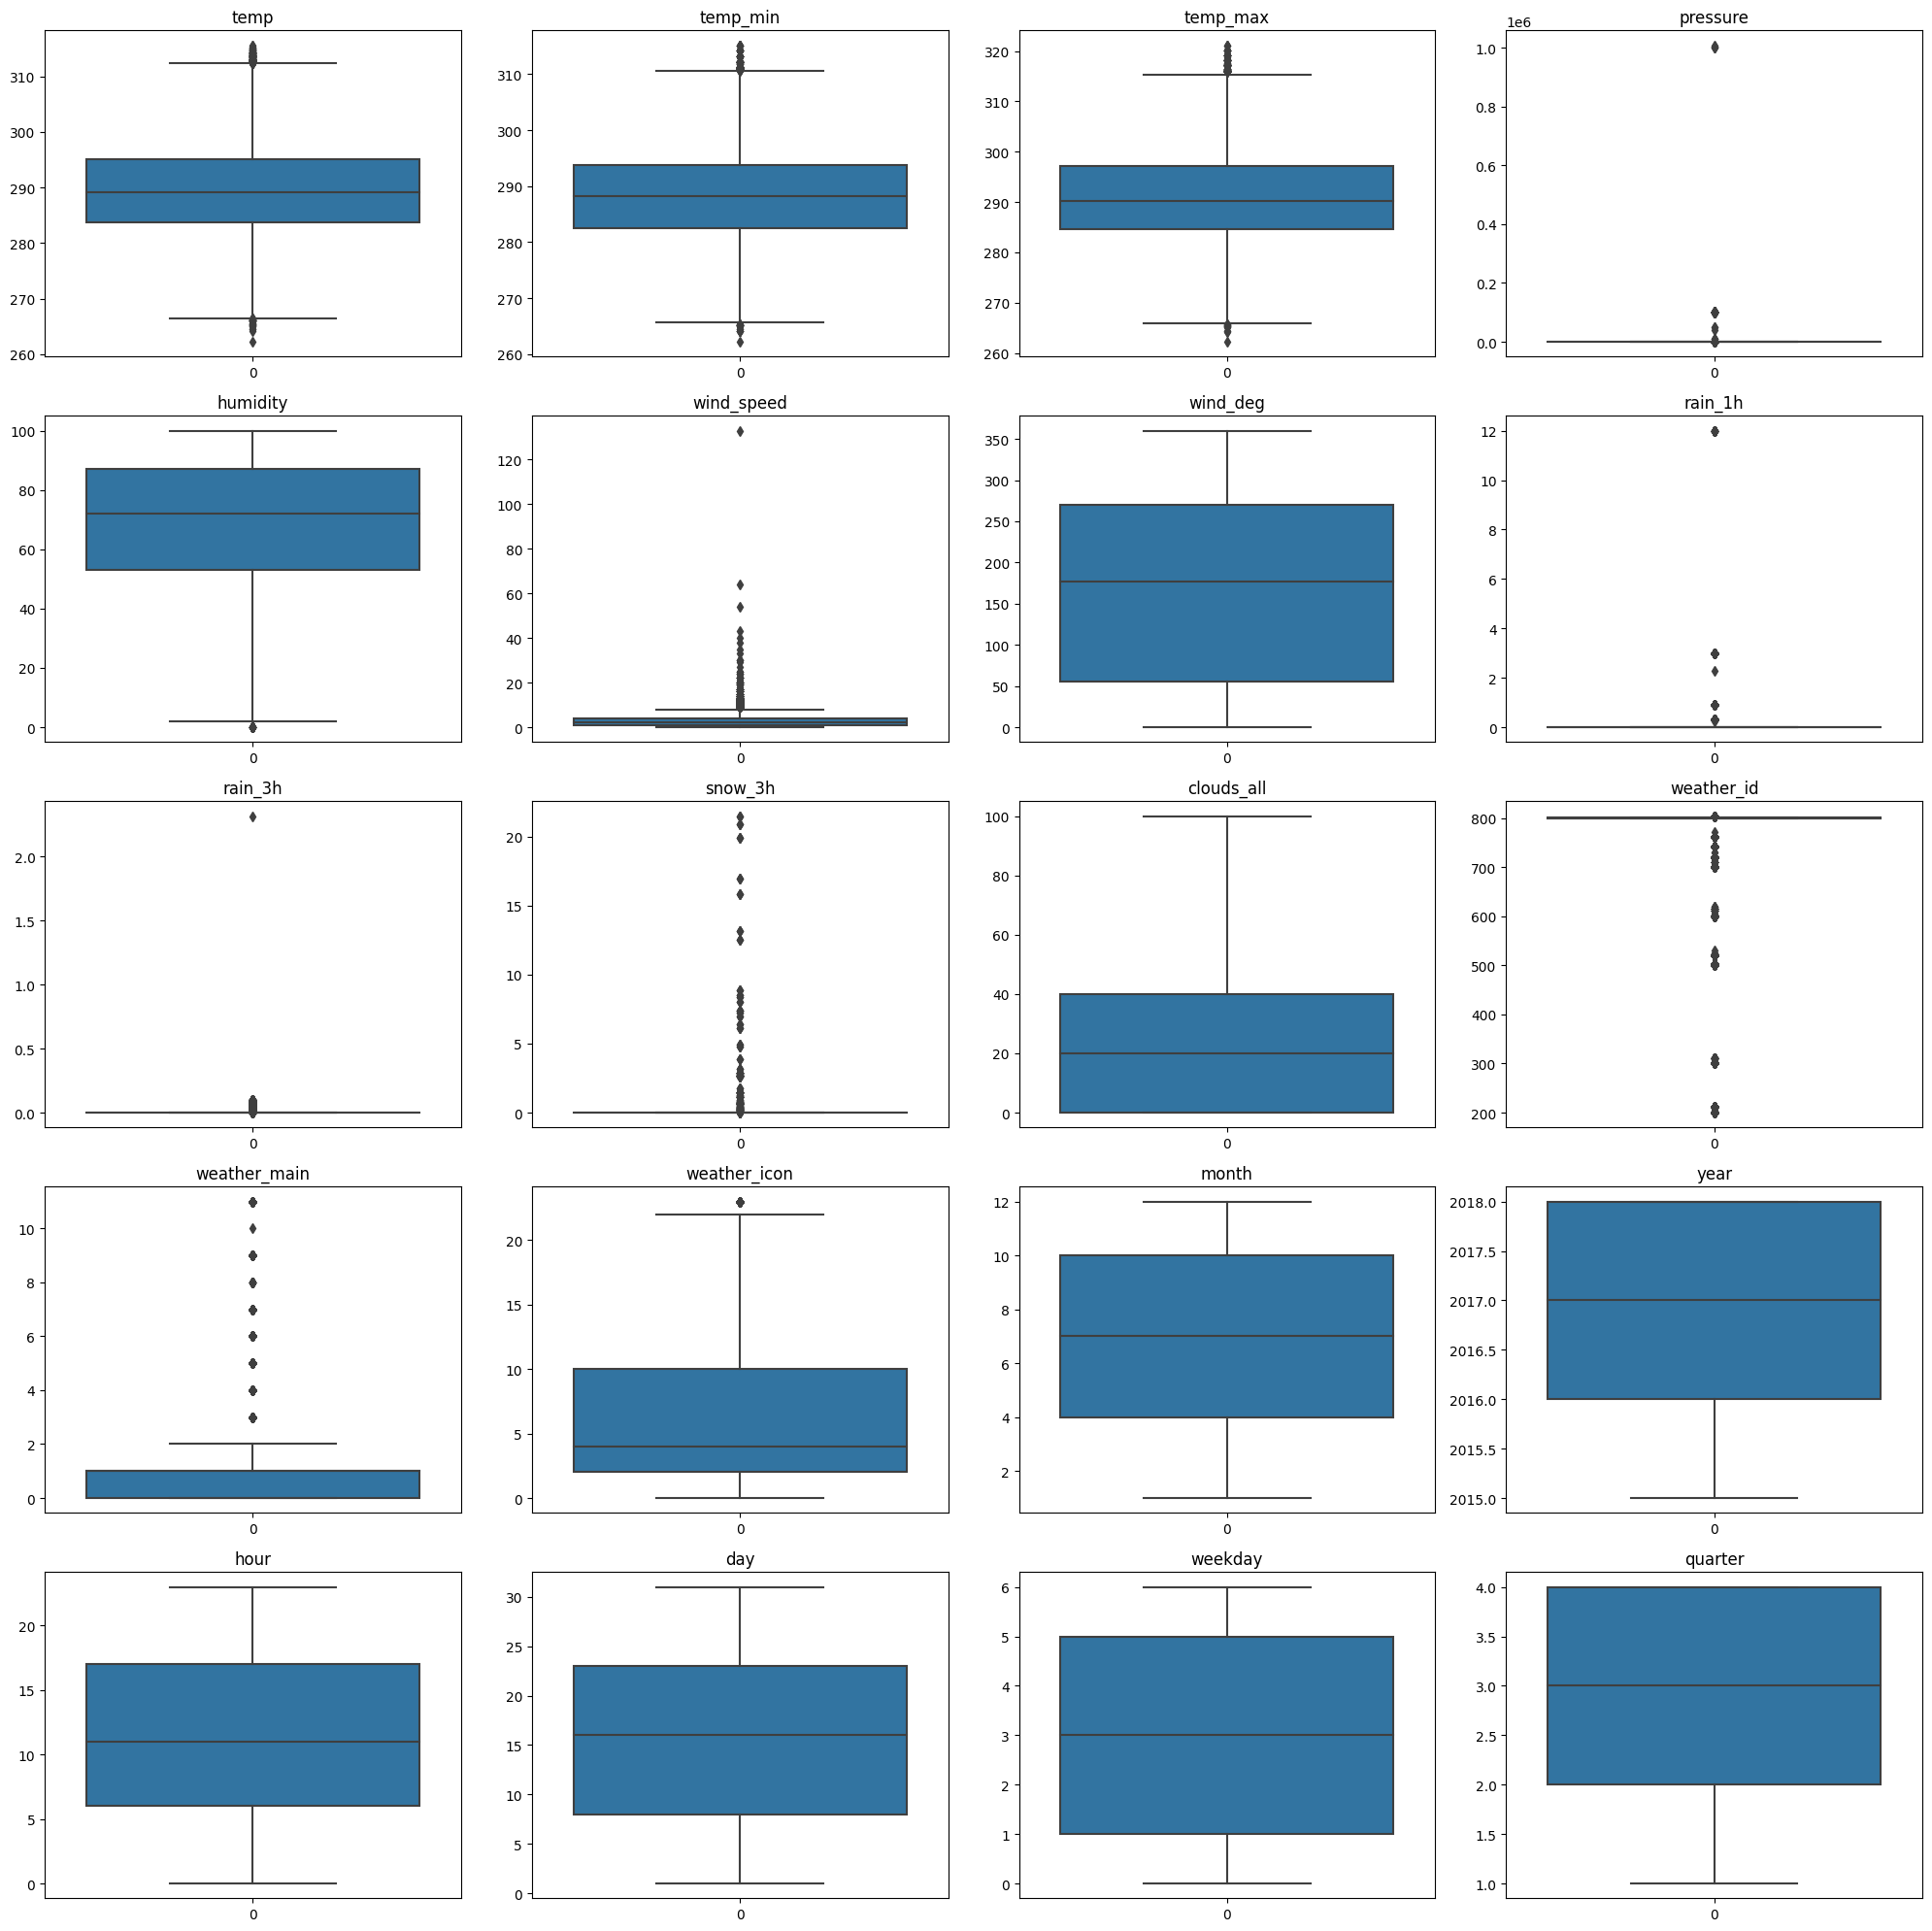

In [11]:
plt.figure(figsize=(20,20))
cols = 4
rows = 5
for i, col in enumerate(weather_pred.columns):
    plt.subplot(rows, cols, i+1)
    sns.boxplot(weather_pred[col])
    plt.title(col)
    plt.tight_layout()


In [12]:
# Remove the outliers.
z=np.abs(zscore(weather_pred))
z

,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_icon,month,year,hour,day,weekday,quarter
0,2.385146,2.244424,2.393780,0.011435,0.391572,0.701635,0.896919,0.189276,0.052105,0.021396,0.814755,0.36942,0.59669,0.67745,1.596266,1.349700,1.663344,1.672196,0.002679,1.346888
1,2.385146,2.244424,2.393780,0.011435,0.391572,0.701635,0.896919,0.189276,0.052105,0.021396,0.814755,0.36942,0.59669,0.67745,1.596266,1.349700,1.518608,1.672196,0.002679,1.346888
2,2.483450,2.343601,2.485392,0.011267,0.437229,1.178756,1.231363,0.189276,0.052105,0.021396,0.814755,0.36942,0.59669,0.67745,1.596266,1.349700,1.373872,1.672196,0.002679,1.346888
3,2.483450,2.343601,2.485392,0.011267,0.437229,1.178756,1.231363,0.189276,0.052105,0.021396,0.814755,0.36942,0.59669,0.67745,1.596266,1.349700,1.229136,1.672196,0.002679,1.346888
4,2.483450,2.343601,2.485392,0.011267,0.437229,1.178756,1.231363,0.189276,0.052105,0.021396,0.814755,0.36942,0.59669,0.67745,1.596266,1.349700,1.084400,1.672196,0.002679,1.346888
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178391,0.231568,0.148381,0.341514,0.006912,0.658520,0.252607,1.171335,0.189276,0.052105,0.021396,0.814755,0.36942,0.59669,0.67745,1.581862,1.334204,1.086639,1.734375,1.502287,1.330440
178392,0.480753,0.399781,0.573737,0.006744,0.293271,0.252607,1.171335,0.189276,0.052105,0.021396,0.814755,0.36942,0.59669,0.67745,1.581862,1.334204,1.231375,1.734375,1.502287,1.330440
178393,0.556754,0.399781,0.689848,0.006912,0.475896,0.729728,0.999825,0.189276,0.052105,0.021396,0.814755,0.36942,0.59669,0.67745,1.581862,1.334204,1.376111,1.734375,1.502287,1.330440
178394,0.681346,0.525480,0.805959,0.006744,0.521552,0.729728,0.914070,0.189276,0.052105,0.021396,0.814755,0.36942,0.59669,0.67745,1.581862,1.334204,1.520847,1.734375,1.502287,1.330440


In [13]:
threshold=3
print(np.where(z>3))

weather_pred_new=weather_pred[(z<3).all(axis=1)]
weather_pred_new

(array([   230,    231,    232, ..., 177944, 178018, 178087], dtype=int64), array([ 5,  5,  5, ...,  5, 11,  7], dtype=int64))


,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_icon,month,year,hour,day,weekday,quarter
0,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,0,2,1,2015,0,1,3,1
1,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,0,2,1,2015,1,1,3,1
2,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,0,2,1,2015,2,1,3,1
3,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,0,2,1,2015,3,1,3,1
4,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,0,2,1,2015,4,1,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178391,287.760,287.150,288.150,1028,54,3,30,0.0,0.0,0.0,0,800,0,2,12,2018,19,31,0,4
178392,285.760,285.150,286.150,1029,62,3,30,0.0,0.0,0.0,0,800,0,2,12,2018,20,31,0,4
178393,285.150,285.150,285.150,1028,58,4,50,0.0,0.0,0.0,0,800,0,2,12,2018,21,31,0,4
178394,284.150,284.150,284.150,1029,57,4,60,0.0,0.0,0.0,0,800,0,2,12,2018,22,31,0,4


    6. Check for skewness and remove (if any)

In [14]:
weather_pred_new.skew()

temp             0.202797
temp_min         0.192616
temp_max         0.266309
pressure        -7.805702
humidity        -0.509129
wind_speed       0.936528
wind_deg        -0.012216
rain_1h          4.280140
rain_3h         17.895496
snow_3h         70.831317
clouds_all       1.017953
weather_id      -2.676712
weather_main     2.061450
weather_icon     1.429807
month           -0.031418
year            -0.021491
hour             0.015403
day              0.007147
weekday         -0.000850
quarter         -0.034399
dtype: float64

In [15]:
weather_pred_new = pd.DataFrame(power_transform(weather_pred_new, method='yeo-johnson'), columns=weather_pred.columns)
weather_pred_new

,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_icon,month,year,hour,day,weekday,quarter
0,-2.623656,-2.428622,-2.733488,-1.323608,0.351225,-0.681906,-0.644381,-0.325148,-0.073252,-0.020422,-1.019713,0.327527,-0.976243,-0.556678,-1.726353,-1.353127,-1.904905,-1.891987,0.078201,-1.404360
1,-2.623656,-2.428622,-2.733488,-1.323608,0.351225,-0.681906,-0.644381,-0.325148,-0.073252,-0.020422,-1.019713,0.327527,-0.976243,-0.556678,-1.726353,-1.353127,-1.651863,-1.891987,0.078201,-1.404360
2,-2.745668,-2.548017,-2.856226,-1.252159,0.402453,-1.825665,-1.155529,-0.325148,-0.073252,-0.020422,-1.019713,0.327527,-0.976243,-0.556678,-1.726353,-1.353127,-1.434204,-1.891987,0.078201,-1.404360
3,-2.745668,-2.548017,-2.856226,-1.252159,0.402453,-1.825665,-1.155529,-0.325148,-0.073252,-0.020422,-1.019713,0.327527,-0.976243,-0.556678,-1.726353,-1.353127,-1.236746,-1.891987,0.078201,-1.404360
4,-2.745668,-2.548017,-2.856226,-1.252159,0.402453,-1.825665,-1.155529,-0.325148,-0.073252,-0.020422,-1.019713,0.327527,-0.976243,-0.556678,-1.726353,-1.353127,-1.053068,-1.891987,0.078201,-1.404360
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170307,-0.200697,-0.118923,-0.303901,1.046813,-0.732730,0.563457,-1.044671,-0.325148,-0.073252,-0.020422,-1.019713,0.327527,-0.976243,-0.556678,1.489377,1.335601,1.055778,1.593554,-1.619797,1.285295
170308,-0.458422,-0.375895,-0.550847,1.154618,-0.377015,0.563457,-1.044671,-0.325148,-0.073252,-0.020422,-1.019713,0.327527,-0.976243,-0.556678,1.489377,1.335601,1.174763,1.593554,-1.619797,1.285295
170309,-0.538125,-0.375895,-0.676779,1.046813,-0.557859,0.987459,-0.779994,-0.325148,-0.073252,-0.020422,-1.019713,0.327527,-0.976243,-0.556678,1.489377,1.335601,1.292140,1.593554,-1.619797,1.285295
170310,-0.669915,-0.506305,-0.804388,1.154618,-0.602145,0.987459,-0.666095,-0.325148,-0.073252,-0.020422,-1.019713,0.327527,-0.976243,-0.556678,1.489377,1.335601,1.408000,1.593554,-1.619797,1.285295


# Exploratory Data Analysis

    Check for correlation
            Making different graphs for checking relationships between the variables 

In [16]:
# find correlation
weather_pred_new.corr()

,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_icon,month,year,hour,day,weekday,quarter
temp,1.000000,0.973925,0.969671,-0.088303,-0.559907,0.164037,-0.014226,-0.154473,-0.012832,-0.035483,-0.144219,0.204542,-0.172765,-0.224140,0.232136,-0.022981,0.260260,0.000615,-0.000443,0.227916
temp_min,0.973925,1.000000,0.896066,-0.100294,-0.554964,0.162479,-0.002331,-0.145736,-0.005380,-0.031839,-0.132999,0.209958,-0.173619,-0.232101,0.213136,0.004110,0.263586,0.005842,0.000361,0.212065
temp_max,0.969671,0.896066,1.000000,-0.066859,-0.523864,0.147691,-0.033229,-0.154845,-0.020392,-0.037789,-0.154189,0.183680,-0.165181,-0.203768,0.236149,-0.044972,0.235636,-0.001691,-0.001519,0.229717
pressure,-0.088303,-0.100294,-0.066859,1.000000,0.083401,-0.138422,-0.074526,-0.110849,0.002644,-0.002588,-0.107992,0.046217,-0.093848,-0.090472,0.122122,0.008581,-0.020405,-0.004741,-0.003020,0.112214
humidity,-0.559907,-0.554964,-0.523864,0.083401,1.000000,-0.287683,-0.054794,0.272007,0.026225,0.022130,0.333107,-0.331272,0.366999,0.441480,0.008422,0.006417,-0.319686,0.025763,0.008502,0.019548
wind_speed,0.164037,0.162479,0.147691,-0.138422,-0.287683,1.000000,0.369804,0.027217,-0.019379,-0.003325,0.083683,0.031683,0.064261,0.005340,-0.109773,0.011643,0.206473,-0.018561,-0.001386,-0.113943
wind_deg,-0.014226,-0.002331,-0.033229,-0.074526,-0.054794,0.369804,1.000000,0.038942,0.004321,0.007193,0.035098,0.000733,0.018356,0.003822,-0.079204,-0.041420,0.018804,-0.007522,0.006547,-0.084886
rain_1h,-0.154473,-0.145736,-0.154845,-0.110849,0.272007,0.027217,0.038942,1.000000,-0.023818,0.055965,0.356745,-0.861956,0.571538,0.470550,-0.077199,-0.043262,0.003924,0.005671,0.006349,-0.076804
rain_3h,-0.012832,-0.005380,-0.020392,0.002644,0.026225,-0.019379,0.004321,-0.023818,1.000000,-0.001496,0.024739,0.031262,0.003284,-0.013684,-0.019956,-0.076371,-0.005924,0.005148,-0.004752,-0.024863
snow_3h,-0.035483,-0.031839,-0.037789,-0.002588,0.022130,-0.003325,0.007193,0.055965,-0.001496,1.000000,0.025930,-0.047930,0.033218,0.026671,-0.029132,-0.025090,-0.006212,-0.011406,-0.007231,-0.028680


    Plot correlation using heatmap

<AxesSubplot: >

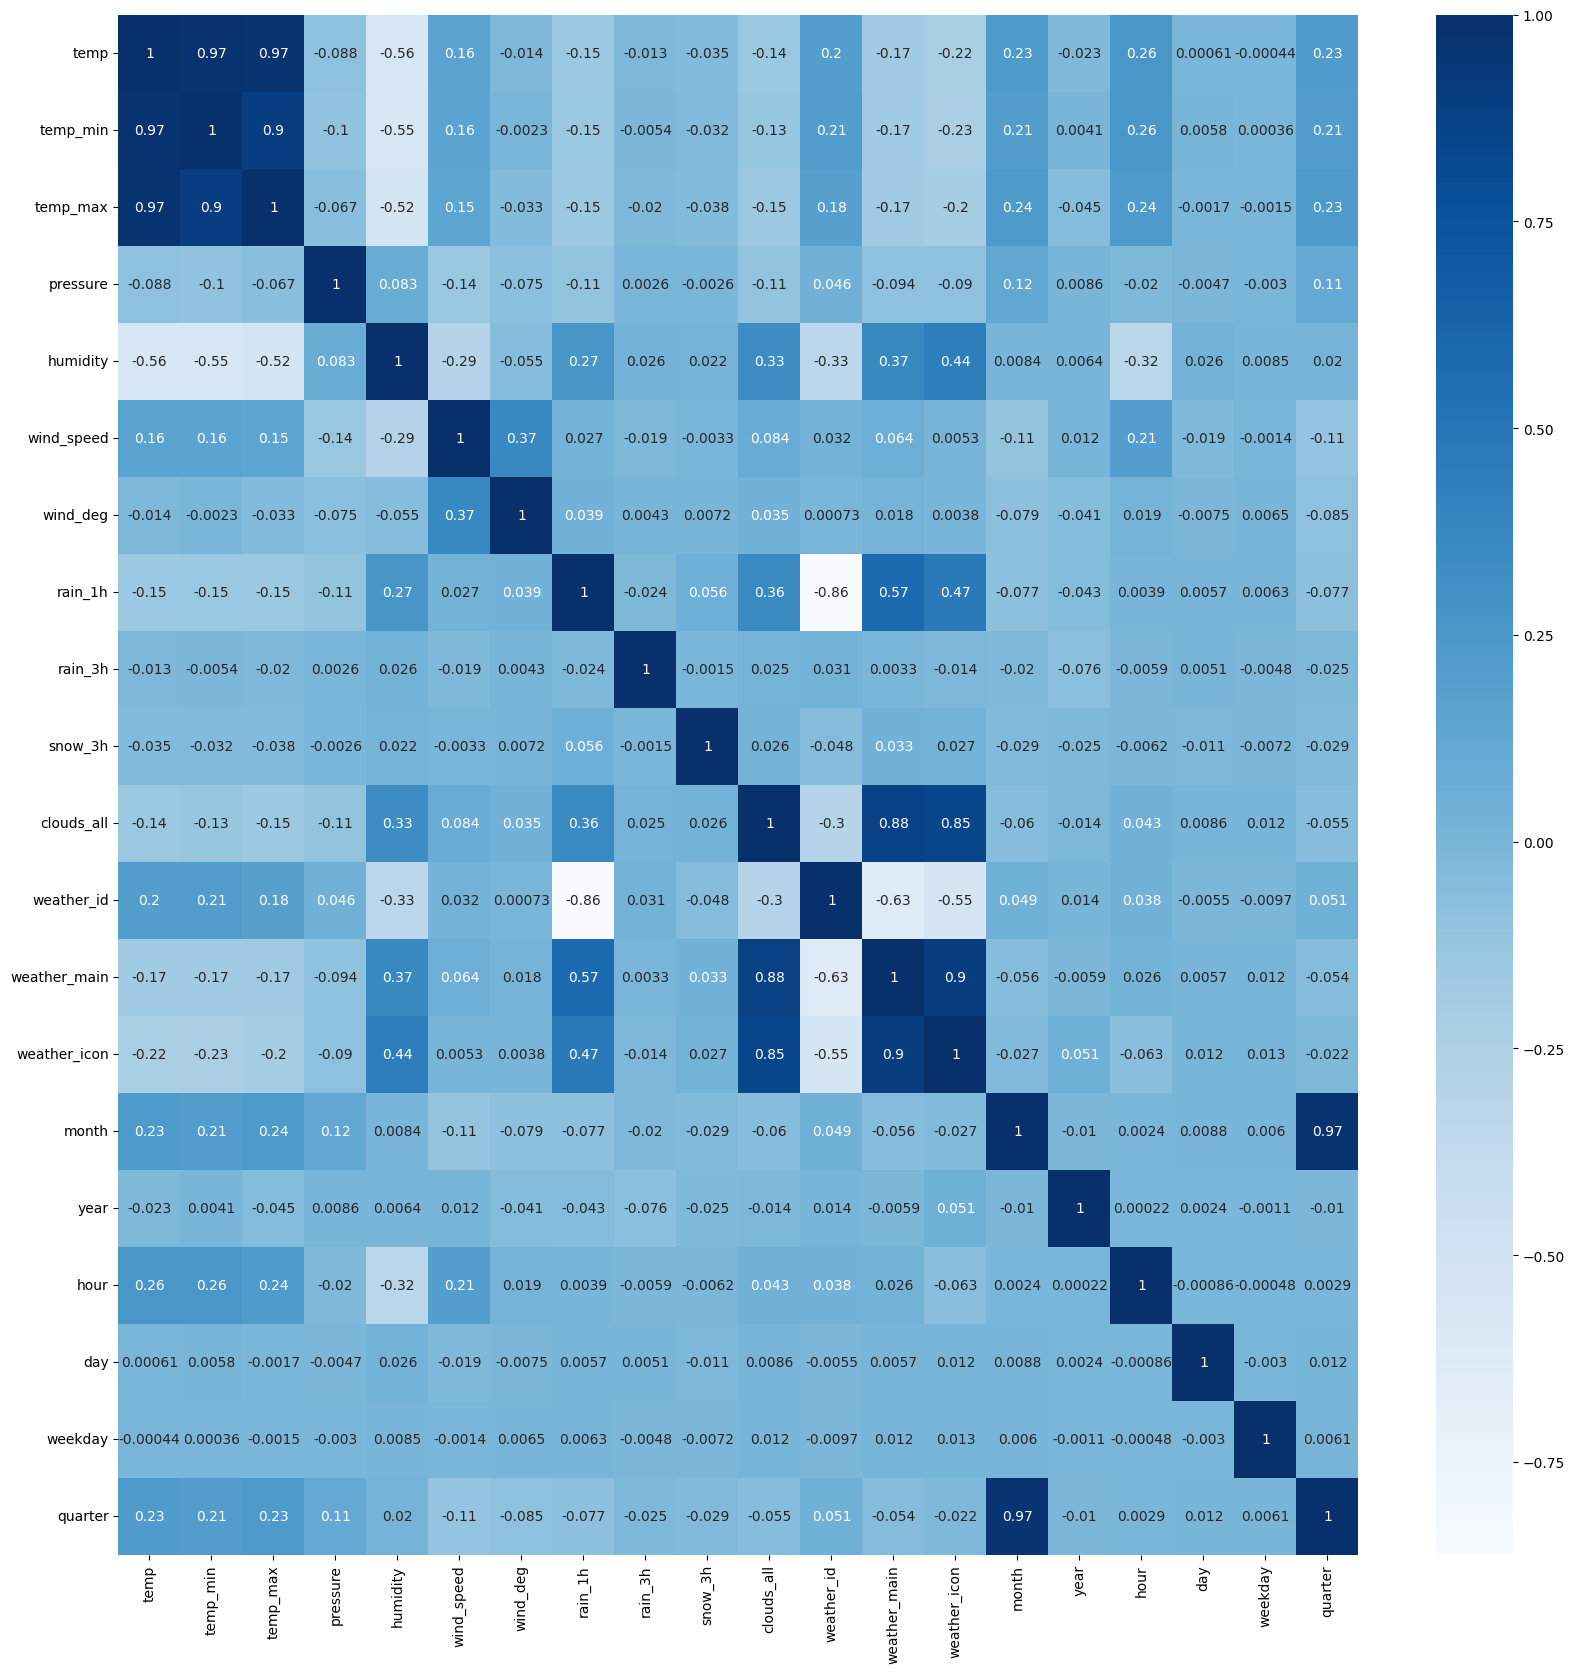

In [17]:
# Visualize the correlation.
plt.figure(figsize=(20,20))
sns.heatmap(weather_pred_new.corr(),annot=True,cmap='Blues')

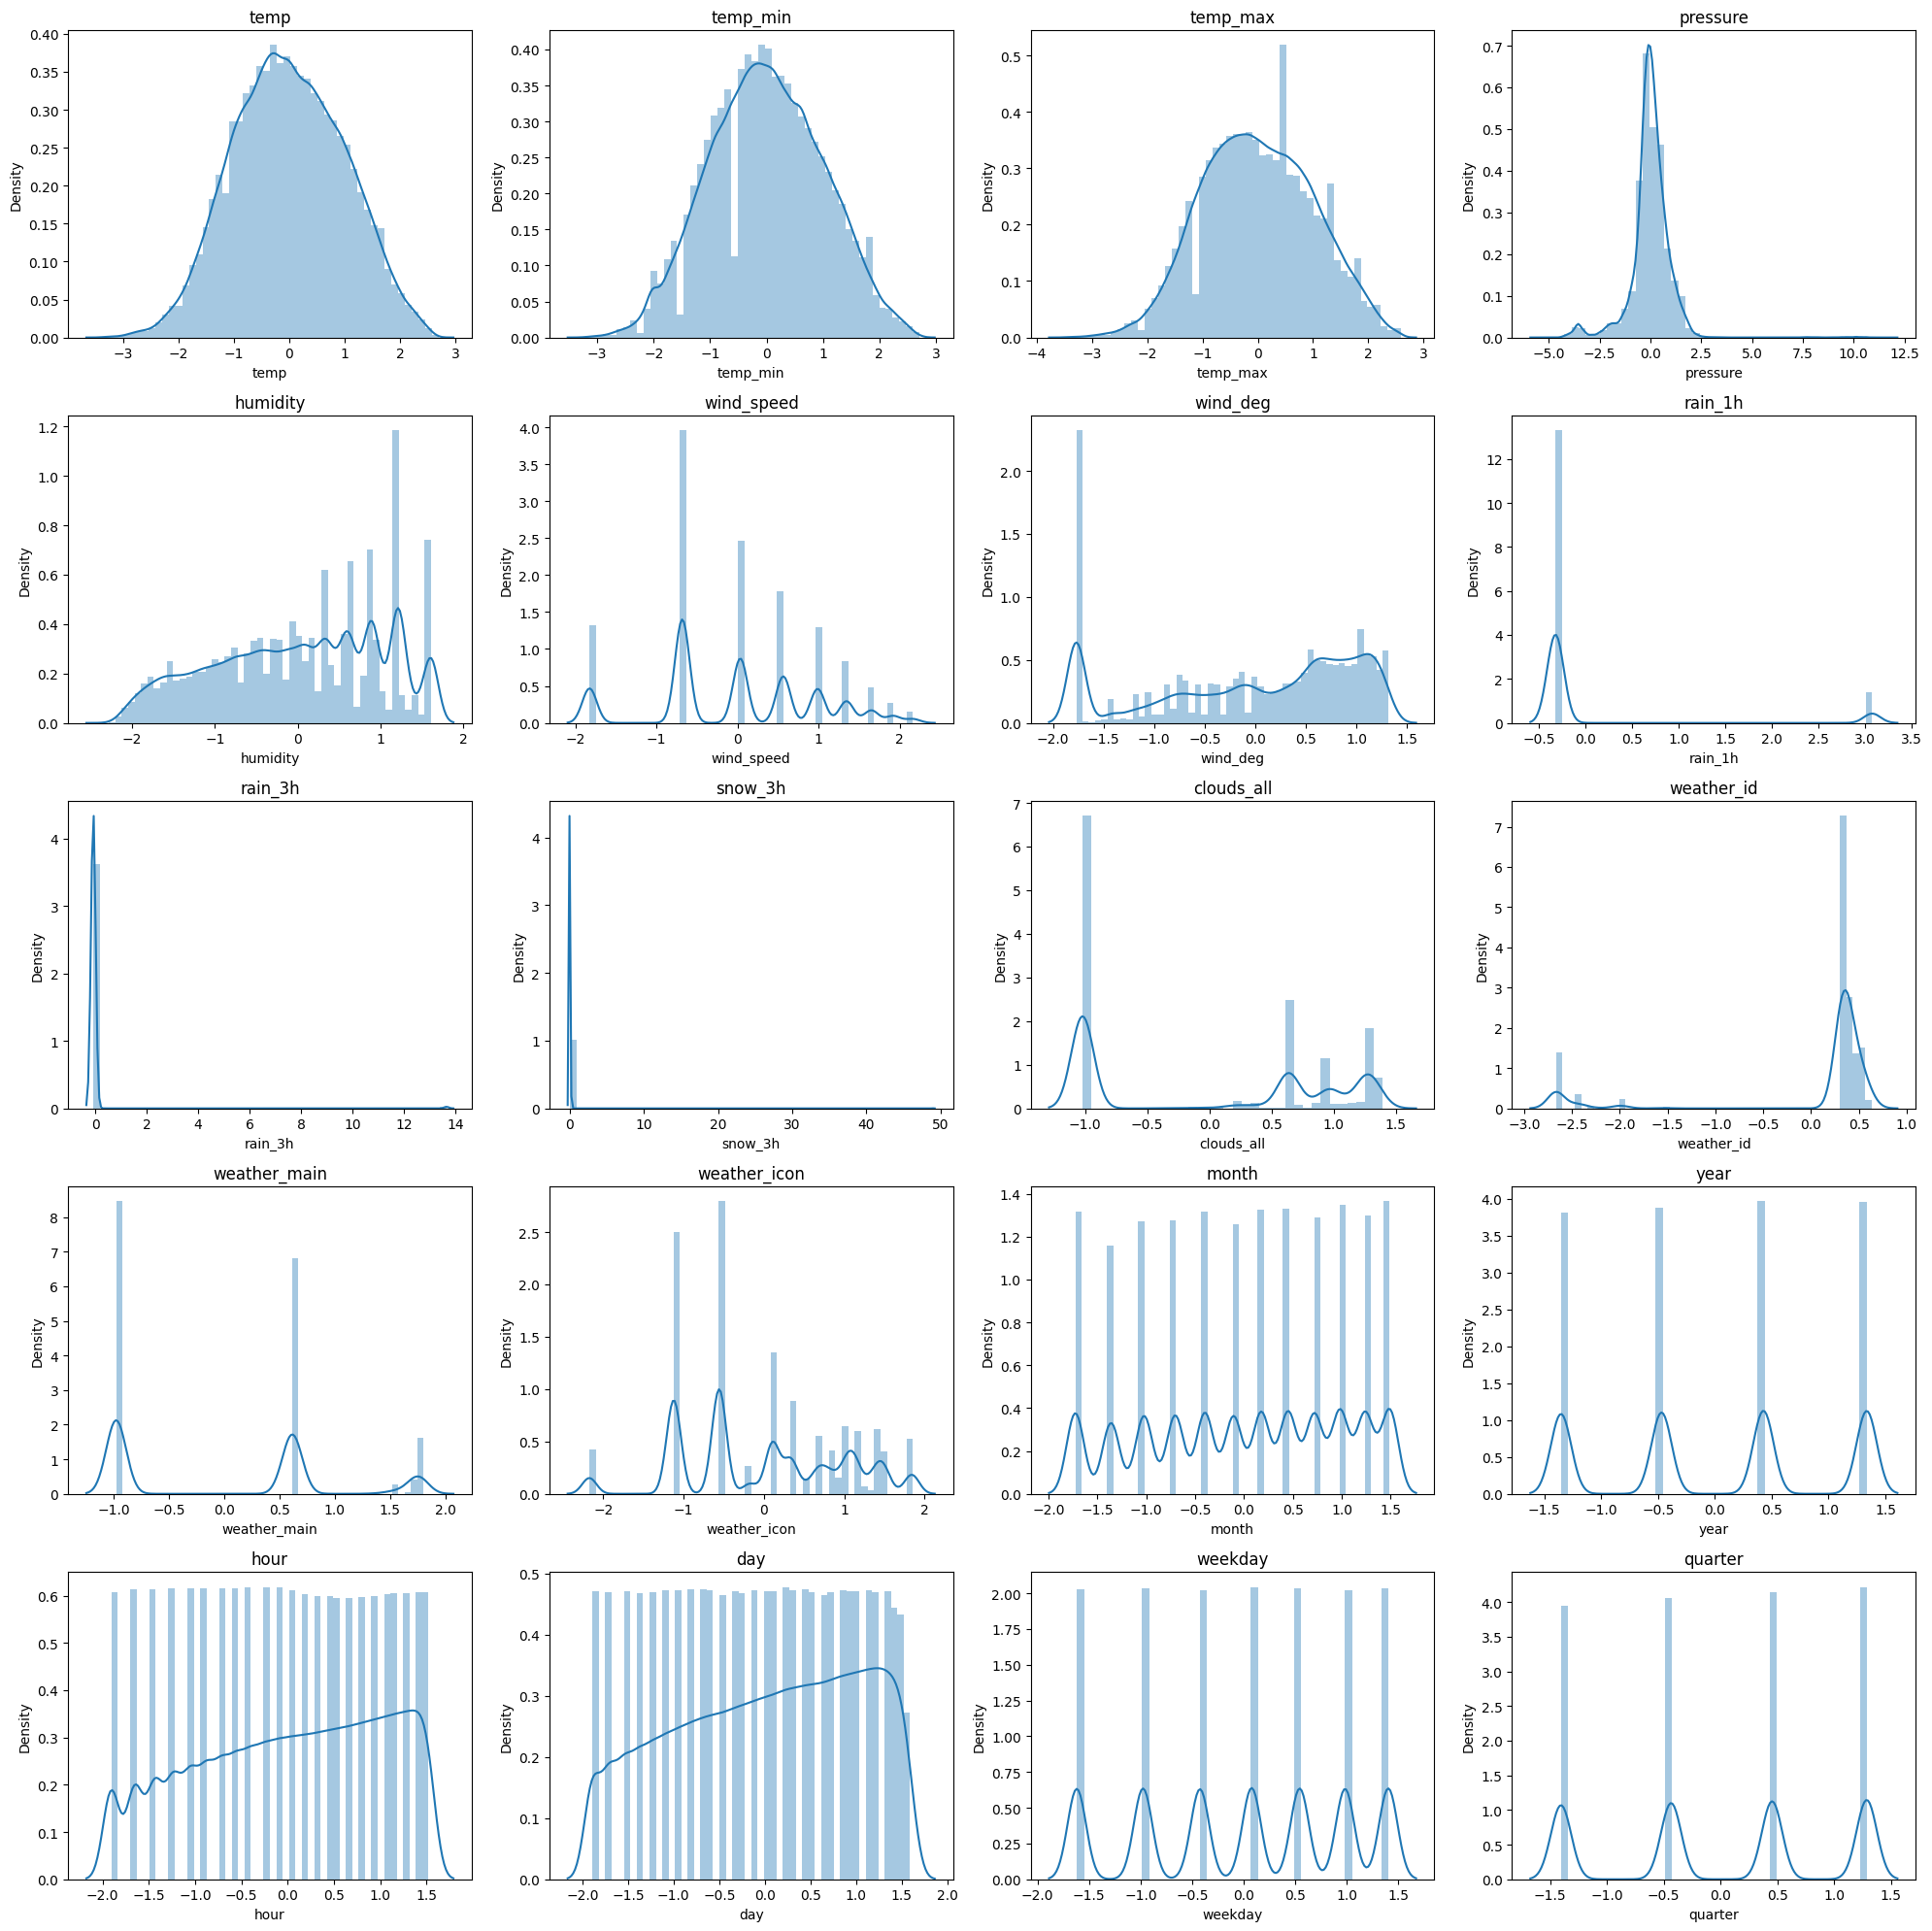

In [18]:
# Identifying potential predictors and understand the relationships between different variables
# Visualize the data using appropriate plots.
plt.figure(figsize=(20,20))
cols = 4
rows = 5
for i, col in enumerate(weather_pred_new.columns):
    plt.subplot(rows, cols, i+1)
    sns.distplot(weather_pred_new[col])
    plt.title(col)
    plt.tight_layout()


## Feature Selection

    Train/Test Splitting the Data

In [19]:
# columns: temp	temp_min, temp_max, pressure, humidity, wind_speed, wind_deg, rain_1h, rain_3h, snow_3h,clouds_all,	weather_id,weather_main,weather_icon,month,	year,hour,day,weekday,quarter

X= weather_pred_new.drop('temp',axis=1)
y= weather_pred_new['temp']

In [20]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

    Best feature Selection
        Using Random Forest Regressor

In [54]:
k=5
model = RandomForestRegressor()
model.fit(X, y)
importances = model.feature_importances_
selected_feature_indices = np.argsort(importances)[-k:]
selected_features = X.columns[selected_feature_indices]

In [55]:
selected_features

Index(['wind_deg', 'pressure', 'humidity', 'temp_max', 'temp_min'], dtype='object')

# Model Selection and Training

    Check for Stationary of Data

In [57]:
# Check for stationary of data
def adfuller_test(temp):
    result=adfuller(temp)
    labels=['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value))
    if result[1]<=0.05:
        print('Data is stationary')
    else:
        print('Data is non-stationary')



In [58]:
adfuller_test(weather_pred_new['temp'])

ADF Test Statistic : -9.613389657386811
p-value : 1.7867980436530427e-16
#Lags Used : 76
Number of Observations Used : 170235
Data is stationary


### Depending on Data: Apply Suitable Models
    

    Apply Linear Regression

In [64]:
# depending on above selected features apply linear regression
X_train = X_train[selected_features]
X_test = X_test[selected_features]

In [76]:
X_train

,wind_deg,pressure,humidity,temp_max,temp_min
30699,-0.194831,-0.127548,0.402453,1.050781,1.434740
22217,-0.035295,-0.127548,-0.689583,1.358414,1.766720
151492,-1.770763,0.335998,0.932117,1.751152,0.133030
158725,-1.770763,-0.303322,0.351225,0.399481,0.501837
59820,-1.770763,-0.216104,0.610563,-2.179190,-2.031070
...,...,...,...,...,...
119879,0.742558,0.240454,-0.859834,-0.303901,-0.246774
103694,0.320121,0.836008,0.716510,-1.091828,-0.798499
131932,-0.279586,-0.127548,-1.403752,1.358414,1.546441
146867,1.072659,-0.473816,0.877756,1.458428,0.007672


In [77]:
X_test

,wind_deg,pressure,humidity,temp_max,temp_min
4900,1.072659,0.053659,0.402453,0.839161,0.689414
96919,1.223942,-0.037633,0.932117,-0.063334,-0.246774
145362,1.174224,-0.037633,-1.023716,0.731330,-0.506305
98122,-0.666095,-0.037633,-0.046740,0.731330,0.860075
165777,0.690828,-0.127548,-0.859834,1.050781,1.321980
...,...,...,...,...,...
28404,-1.770763,-0.127548,0.610563,0.054622,0.380097
134067,-0.560551,-0.389220,0.149579,0.399481,0.741811
106527,0.449254,0.053659,-0.377015,1.950663,1.080520
169433,0.385469,0.053659,0.558059,-0.804388,-0.638021


In [68]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr= lr.predict(X_test)
y_pred_lr

array([ 0.77629542, -0.16621986,  0.10416632, ...,  1.53448373,
       -0.73644796,  0.88640929])

    Model Evaluation: Linear Regressor

In [69]:
print('R2 score:',r2_score(y_test,y_pred_lr))
print('Mean Absolute Error:',mean_absolute_error(y_test,y_pred_lr))
print('Mean Squared Error:',mean_squared_error(y_test,y_pred_lr))
print('Root Mean Squared Error:',np.sqrt(mean_squared_error(y_test,y_pred_lr)))

R2 score: 0.9961084447639681
Mean Absolute Error: 0.028116707843127593
Mean Squared Error: 0.003890867233126588
Root Mean Squared Error: 0.06237681647155927


In [84]:
# CALCULATE ACCURACY
print('Accuracy score:',lr.score(X_test,y_test))


Accuracy score: 0.9961084447639681


    Apply Random Forest

In [71]:
# Apply random forest regressor on the features extracted from the above step.
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_pred_rf




array([ 0.79150379, -0.16127859,  0.02066544, ...,  1.68039629,
       -0.74541603,  0.86949555])

    Model Evaluation: Random Forest Regressor

In [73]:

print('R2 score:',r2_score(y_test,y_pred_rf))
print('Mean Absolute Error:',mean_absolute_error(y_test,y_pred_rf))
print('Mean Squared Error:',mean_squared_error(y_test,y_pred_rf))
print('Root Mean Squared Error:',np.sqrt(mean_squared_error(y_test,y_pred_rf)))

R2 score: 0.998475979860189
Mean Absolute Error: 0.017932250639017235
Mean Squared Error: 0.0015237507024728411
Root Mean Squared Error: 0.039035249486494145


In [85]:
print('Accuracy score:',rf.score(X_test,y_test))

Accuracy score: 0.998475979860189


    Apply XGBoost

In [86]:
# apply xgboost regressor
xgb = XGBRegressor()
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
y_pred_xgb


array([ 0.8098236 , -0.17239706,  0.08424418, ...,  1.6455697 ,
       -0.7377327 ,  0.87900704], dtype=float32)

    Model Evaluation: XGBoost

In [88]:
print('R2 score:',r2_score(y_test,y_pred_rf))
print('Mean Absolute Error:',mean_absolute_error(y_test,y_pred_rf))
print('Mean Squared Error:',mean_squared_error(y_test,y_pred_rf))
print('Root Mean Squared Error:',np.sqrt(mean_squared_error(y_test,y_pred_rf)))

R2 score: 0.998475979860189
Mean Absolute Error: 0.017932250639017235
Mean Squared Error: 0.0015237507024728411
Root Mean Squared Error: 0.039035249486494145


    Apply Decision Tree

In [91]:
# apply decision tree
dt = DecisionTreeRegressor()
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
y_pred_dt



array([ 0.81986009, -0.1257056 , -0.00593341, ...,  1.76492901,
       -0.74566852,  0.86883415])

    Model Evaluation: Decision Tree

In [95]:
# CALCULATE ACCURACY
print('Accuracy score:',dt.score(X_test,y_test))
print('R2 score:',r2_score(y_test,y_pred_dt))
print('Mean Absolute Error:',mean_absolute_error(y_test,y_pred_dt))
print('Mean Squared Error:',mean_squared_error(y_test,y_pred_dt))
print('Root Mean Squared Error:',np.sqrt(mean_squared_error(y_test,y_pred_dt)))

Accuracy score: 0.997404371138288
R2 score: 0.997404371138288
Mean Absolute Error: 0.02268473785813342
Mean Squared Error: 0.002595169970577328
Root Mean Squared Error: 0.05094281078402848


# Optimizing the above models by finding the best hyper parameters

    Linear Regressor (Optimised)

In [104]:
lr_op = LinearRegression()

# Define the hyperparameter grid
parameters = {
    'fit_intercept': [True, False],
    'positive': [True, False]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=lr_op, param_grid=parameters, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best parameters and best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Use the best model to make predictions
y_pred_lr_op = best_model.predict(X_test)


In [105]:
# Apply Linear Regressor on Optimised Parameters
lr_op = LinearRegression()
lr_op.fit(X_train, y_train)
y_pred_lr_op = lr_op.predict(X_test)
y_pred_lr_op


array([ 0.77629542, -0.16621986,  0.10416632, ...,  1.53448373,
       -0.73644796,  0.88640929])

In [106]:
# CALCULATE ACCURACY
print('Accuracy score:',lr_op.score(X_test,y_test))
print('R2 score:',r2_score(y_test,y_pred_lr_op))
print('Mean Absolute Error:',mean_absolute_error(y_test,y_pred_lr_op))
print('Mean Squared Error:',mean_squared_error(y_test,y_pred_lr_op))
print('Root Mean Squared Error:',np.sqrt(mean_squared_error(y_test,y_pred_lr_op)))


Accuracy score: 0.9961084447639681
R2 score: 0.9961084447639681
Mean Absolute Error: 0.028116707843127593
Mean Squared Error: 0.003890867233126588
Root Mean Squared Error: 0.06237681647155927


    Random Forest (Optimised)

In [113]:
rf_op = RandomForestRegressor()

# Define the hyperparameter grid
parameters = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 3, 5]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=rf_op, param_grid=parameters, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best parameters and best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Use the best model to make predictions
y_pred_rf_op = best_model.predict(X_test)



In [115]:
# Apply Random Forest Regressor on Optimised Parameters
rf_op = RandomForestRegressor()
rf_op.fit(X_train, y_train)
y_pred_rf_op = rf_op.predict(X_test)
y_pred_rf_op

array([ 0.79639722, -0.16358571,  0.01550219, ...,  1.68218394,
       -0.74481712,  0.87002342])

In [116]:
# calculate accuracy
print('Accuracy score:',rf_op.score(X_test,y_test))
print('R2 score:',r2_score(y_test,y_pred_rf_op))
print('Mean Absolute Error:',mean_absolute_error(y_test,y_pred_rf_op))
print('Mean Squared Error:',mean_squared_error(y_test,y_pred_rf_op))
print('Root Mean Squared Error:',np.sqrt(mean_squared_error(y_test,y_pred_rf_op)))

Accuracy score: 0.998475887151116
R2 score: 0.998475887151116
Mean Absolute Error: 0.017954983769838753
Mean Squared Error: 0.0015238433951554697
Root Mean Squared Error: 0.03903643676304831


    XGBoost (Optimised)

In [110]:
xgb_op=XGBRegressor()

# Define the hyperparameter grid
parameters = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'learning_rate': [0.1, 0.2, 0.3]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=xgb_op, param_grid=parameters, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best parameters and best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Use the best model to make predictions
y_pred_xgb_op = best_model.predict(X_test)


In [111]:
# Apply XGBoost Regressor on Optimised Parameters
xgb_op = XGBRegressor()
xgb_op.fit(X_train, y_train)
y_pred_xgb_op = xgb_op.predict(X_test)
y_pred_xgb_op


array([ 0.8098236 , -0.17239706,  0.08424418, ...,  1.6455697 ,
       -0.7377327 ,  0.87900704], dtype=float32)

In [112]:
# CALCULATE ACCURACY
print('Accuracy score:',xgb_op.score(X_test,y_test))
print('R2 score:',r2_score(y_test,y_pred_xgb_op))
print('Mean Absolute Error:',mean_absolute_error(y_test,y_pred_xgb_op))
print('Mean Squared Error:',mean_squared_error(y_test,y_pred_xgb_op))
print('Root Mean Squared Error:',np.sqrt(mean_squared_error(y_test,y_pred_xgb_op)))

Accuracy score: 0.9984675348041788
R2 score: 0.9984675348041788
Mean Absolute Error: 0.020244750851804487
Mean Squared Error: 0.0015321942654493701
Root Mean Squared Error: 0.039143253128085434


    Decision Tree (Optimised)

In [100]:
dt_op = DecisionTreeRegressor()

# Define the hyperparameter grid
parameters = {
    'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9],
    'min_samples_split': [1, 2, 3, 4, 5, 6, 7, 8, 9],
    'criterion': ['squared_error', 'friedman_mse', 'poisson']
}

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=dt_op, param_grid=parameters, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best parameters and best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Use the best model to make predictions
y_pred_dt_op = best_model.predict(X_test)



In [101]:
# applying  decision tree with best parameters
dt_op = DecisionTreeRegressor(criterion='squared_error', max_depth=9, min_samples_leaf=1, min_samples_split=2)
dt_op.fit(X_train, y_train)
y_pred_dt_op = dt_op.predict(X_test)
y_pred_dt_op

array([ 0.78410004, -0.20004915,  0.04694174, ...,  1.52241523,
       -0.70477801,  0.88003637])

In [102]:

# CALCULATE ACCURACY
print('Accuracy score:',dt_op.score(X_test,y_test))
print('R2 score:',r2_score(y_test,y_pred_dt_op))
print('Mean Absolute Error:',mean_absolute_error(y_test,y_pred_dt_op))
print('Mean Squared Error:',mean_squared_error(y_test,y_pred_dt_op))
print('Root Mean Squared Error:',np.sqrt(mean_squared_error(y_test,y_pred_dt_op)))


Accuracy score: 0.9974763506155404
R2 score: 0.9974763506155404
Mean Absolute Error: 0.026407671137820585
Mean Squared Error: 0.002523203218851393
Root Mean Squared Error: 0.050231496283222474


# Creating Pickle files

In [119]:
# Creating pickle files for Linear Regressor (optimised)
filename_lr = 'weather_pred_lr.pkl'
pickle.dump(lr_op, open(filename_lr, 'wb'))

# Creating pickle files for Random Forest Regressor (optimised)
filename_rf = 'weather_pred_rf.pkl'
pickle.dump(rf_op, open(filename_rf, 'wb'))

# Creating pickle files for XGBoost Regressor (optimised)
filename_xgb = 'weather_pred_xgb.pkl'
pickle.dump(xgb_op, open(filename_xgb, 'wb'))

# Creating pickle files for Decision Tree Regressor (optimised)
filename_dt = 'weather_pred_dt.pkl'
pickle.dump(dt_op, open(filename_dt, 'wb'))


In [120]:
# now based on the accuracy, test the models accuracy, prediction by creating a scnerio where data from user is input and mode will predict the output

# load the model
loaded_model_lr = pickle.load(open(filename_lr, 'rb'))
result_lr = loaded_model_lr.score(X_test, y_test)
print(result_lr)


0.9961084447639681


In [121]:
# load the model
loaded_model_rf = pickle.load(open(filename_rf, 'rb'))
result_rf = loaded_model_rf.score(X_test, y_test)
print(result_rf)

0.998475887151116


In [122]:
# load the model
loaded_model_xgb = pickle.load(open(filename_xgb, 'rb'))
result_xgb = loaded_model_xgb.score(X_test, y_test)
print(result_xgb)

0.9984675348041788


In [123]:
# load the model
loaded_model_dt = pickle.load(open(filename_dt, 'rb'))
result_dt = loaded_model_dt.score(X_test, y_test)
print(result_dt)

0.9974763506155404
